Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data...
Data loaded successfully.
Checking distribution of input data...
DescribeResult(nobs=16384000, minmax=(array([-80.]), array([0.])), mean=array([-36.14291558]), variance=array([175.3965816]), skewness=array([-0.63236396]), kurtosis=array([1.15390831]))
DescribeResult(nobs=16384000, minmax=(array([-63.21071553]), array([80.])), mean=array([0.24395273]), variance=array([98.36349307]), skewness=array([0.58090238]), kurtosis=array([2.20435171]))
Distribution check completed.
Scaling input and output data...
Data scaled successfully.
Checking shape of spectrograms...
Input shape: (1000, 128, 128)
Output shape: (1000, 128, 128)
Shape check completed.
Splitting data into train and validation sets...
Data split completed.
Shape of x_train: (900, 128, 128)
Shape of x_val: (100, 128, 128)
Shape of y_train: (900, 128, 128)
Shape of y_val: (100, 128, 128)


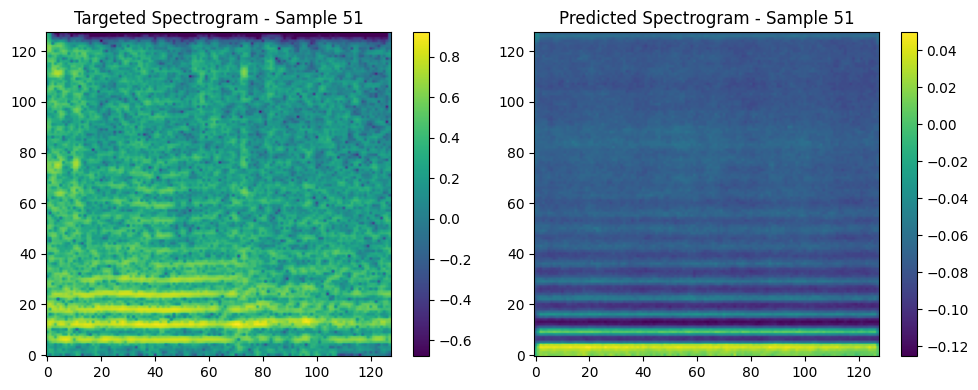

1/1 [==============================] - 0s 35ms/step


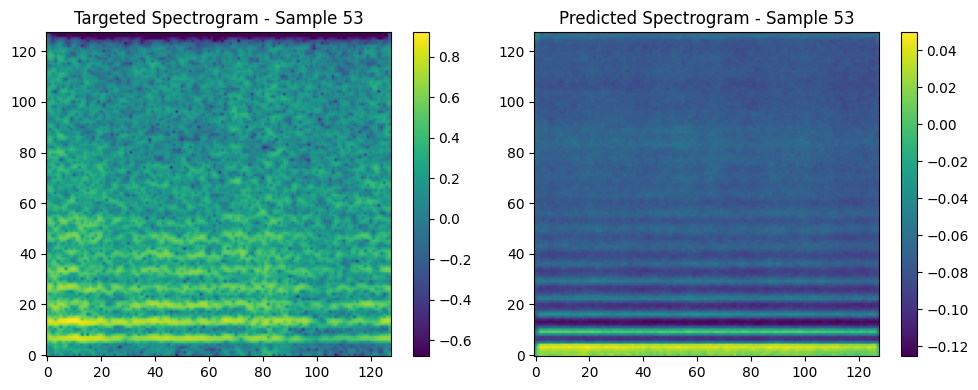

1/1 [==============================] - 0s 32ms/step


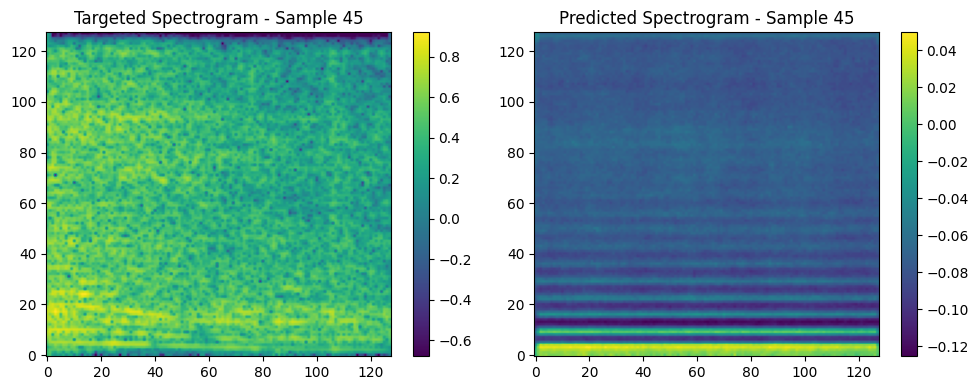

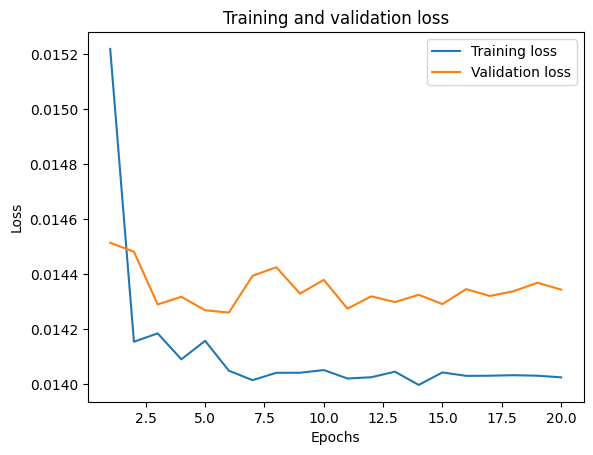

Saving model architecture to JSON file...
Model architecture saved successfully.
Saving model weights...
Model weights saved successfully.
Epochs: range(1, 21)
Training Loss: [0.015219047665596008, 0.014153541065752506, 0.014184041880071163, 0.01408946793526411, 0.01415690965950489, 0.014048151671886444, 0.014013712294399738, 0.014040587469935417, 0.014040677808225155, 0.014050491154193878, 0.014019797556102276, 0.014024387113749981, 0.01404454093426466, 0.013996423222124577, 0.014041830785572529, 0.014029426500201225, 0.01402991358190775, 0.014031813479959965, 0.014029950834810734, 0.014024024829268456]
Validation Loss: [0.014513739384710789, 0.014481072314083576, 0.01428922638297081, 0.014317126013338566, 0.014268188737332821, 0.014259688556194305, 0.014393448829650879, 0.01442461833357811, 0.01432870700955391, 0.01437878143042326, 0.014273932203650475, 0.01431888248771429, 0.014297890476882458, 0.014324450865387917, 0.0142905805259943, 0.014345070347189903, 0.014320027083158493, 0.0

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Reshape, BatchNormalization, LSTM, Dense, Flatten, TimeDistributed, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from scipy import stats
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Mount Google Drive
drive.mount('/content/drive')

# Function to scale input data
def scaled_in(matrix_spec):
    "Global scaling applied to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46) / 50
    return matrix_spec

# Function to scale output data
def scaled_ou(matrix_spec):
    "Global scaling applied to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec - 6) / 82
    return matrix_spec

# Load data
path_save_spectrogram = '/content/drive/MyDrive/npy/New1000/'

print("Loading data...")
X_in = np.load(os.path.join(path_save_spectrogram, 'noisy_voice_amp_db.npy'))
X_ou = np.load(os.path.join(path_save_spectrogram, 'voice_amp_db.npy'))
print("Data loaded successfully.")

# Model of noise to predict
X_ou = X_in - X_ou

# Check distribution
print("Checking distribution of input data...")
print(stats.describe(X_in.reshape(-1, 1)))
print(stats.describe(X_ou.reshape(-1, 1)))
print("Distribution check completed.")

# Scale input and output data
print("Scaling input and output data...")
X_in = scaled_in(X_in)
X_ou = scaled_ou(X_ou)
print("Data scaled successfully.")

# Check shape of spectrograms
print("Checking shape of spectrograms...")
print("Input shape:", X_in.shape)
print("Output shape:", X_ou.shape)
print("Shape check completed.")

# Split data into train and validation sets
print("Splitting data into train and validation sets...")
x_train, x_val, y_train, y_val = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)
print("Data split completed.")
print("Shape of x_train:", x_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

# Reshape input data
x_train_reshaped = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_val_reshaped = x_val.reshape((x_val.shape[0], 1, x_val.shape[1], x_val.shape[2], 1))

# Reshape target data
y_train_reshaped = y_train.reshape((y_train.shape[0], -1))
y_val_reshaped = y_val.reshape((y_val.shape[0], -1))

print("Shape of x_train_reshaped:", x_train_reshaped.shape)
print("Shape of x_val_reshaped:", x_val_reshaped.shape)
print("Shape of y_train_reshaped:", y_train_reshaped.shape)
print("Shape of y_val_reshaped:", y_val_reshaped.shape)

height, width, channels = (128, 128, 1)
input_shape = (128, 128, 1)
num_filters = 32
dense_units = 32

print("Defining model with best hyperparameters...")

rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, 128, 128, 1)),
    TimeDistributed(Conv2D(32, (5, 5), activation="relu")),
    TimeDistributed(MaxPool2D()),
    TimeDistributed(Conv2D(32 * 2, (5, 5), activation="relu")),
    TimeDistributed(MaxPool2D()),
    TimeDistributed(Flatten()),
    TimeDistributed(Dense(dense_units, activation="relu")),
    TimeDistributed(Dense(16384))
])

print("Model defined successfully.")

print("Compiling the model...")
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
)

print("Model compiled successfully.")

# Define filepath for saving the best model
model_checkpoint_path = 'best_model_rnn-ltc-f.keras'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(model_checkpoint_path,
                             verbose=1,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto')

print("Training the RNN model...")
history = rnn_model.fit(x_train_reshaped, y_train_reshaped, validation_data=(x_val_reshaped, y_val_reshaped),
                        epochs=20, batch_size=10, verbose=1, callbacks=[checkpoint])
print("Training completed.")


# Compute MSE and SNR
# Predict on validation data
y_pred = rnn_model.predict(x_val_reshaped)

# Flatten the arrays for MSE calculation
y_val_flat = y_val.reshape(y_val.shape[0], -1)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)

# Compute MSE
mse = mean_squared_error(y_val_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse}")

# Compute SNR
def compute_snr(target, prediction):
    noise = target - prediction
    snr = 10 * np.log10(np.mean(target**2) / np.mean(noise**2))
    return snr

snr = compute_snr(y_val_flat, y_pred_flat)
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

# Display targeted and predicted spectrograms
# Display targeted and predicted spectrograms
# Display targeted and predicted spectrograms
num_samples_to_visualize = 3
sample_indices = np.random.choice(x_val.shape[0], num_samples_to_visualize, replace=False)

for idx in sample_indices:
    plt.figure(figsize=(10, 4))

    # Display targeted spectrogram
    plt.subplot(1, 2, 1)
    plt.imshow(x_val[idx, :, :], cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f"Targeted Spectrogram - Sample {idx}")

    # Display predicted spectrogram
    plt.subplot(1, 2, 2)
    predicted_spec = rnn_model.predict(x_val_reshaped[idx:idx+1])[0].reshape(height, width)
    plt.imshow(predicted_spec, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f"Predicted Spectrogram - Sample {idx}")

    plt.tight_layout()
    plt.show()




# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save model architecture to JSON file
print("Saving model architecture to JSON file...")
model_json = rnn_model.to_json()
with open('model_rnn-ltc-f.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved successfully.")

# Save model weights
print("Saving model weights...")
rnn_model.save_weights('model_rnn_weights-ltc-f.keras')
print("Model weights saved successfully.")

print("Epochs:", epochs)
print("Training Loss:", loss)
print("Validation Loss:", val_loss)
